# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-(weights @ X.T)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return np.log(1 + np.exp(-(weights @ x.T) * y)).mean() + (1 / (2 * self.C)) * (np.linalg.norm(weights) ** 2) 
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = -(X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y))))) / len(y) \
                + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) < 0.5, -1, 1)

In [6]:
from sklearn import datasets
from sklearn import metrics

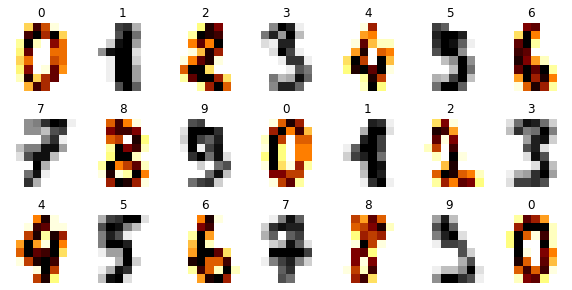

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

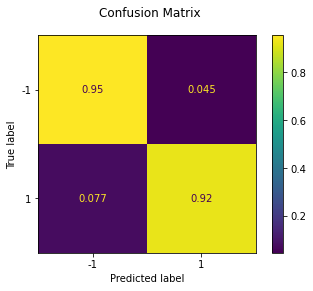

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0.5, 1.0, 'Loss History')

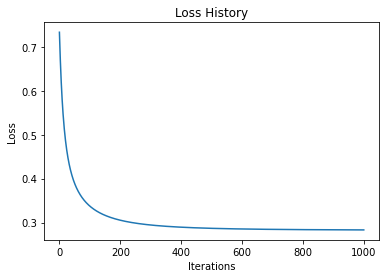

In [18]:
plt.plot(model.loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

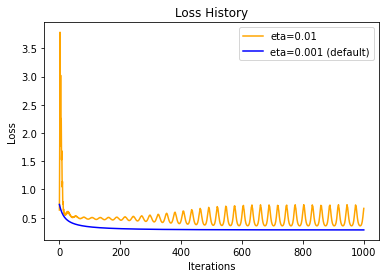

In [19]:
model_eta_01 = CustomLogisticRegression(eta=0.01)
model_eta_01.fit(X_train, y_train)

plt.plot(model_eta_01.loss_history, label='eta=0.01', color='orange')
plt.plot(model.loss_history, label='eta=0.001 (default)', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

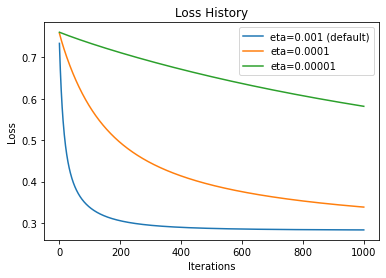

In [20]:
model_eta_0001 = CustomLogisticRegression(eta=0.0001)
model_eta_0001.fit(X_train, y_train)
model_eta_00001 = CustomLogisticRegression(eta=0.00001)
model_eta_00001.fit(X_train, y_train)

plt.plot(model.loss_history, label='eta=0.001 (default)')
plt.plot(model_eta_0001.loss_history, label='eta=0.0001')
plt.plot(model_eta_00001.loss_history, label='eta=0.00001')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

Learning rate that is too large can overshoot the optimal value (may fail to converge or even diverge), whereas a learning rate that is too small may need too many iterations to converge or get stuck on a suboptimal solution.  That's why it is crucial to use a well-tuned learning rate.  
When setting learning rate, we would expect for the loss to decrease and for the model to eventually result in faster convergence.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

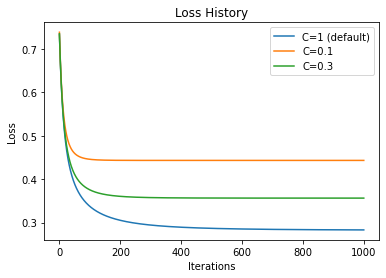

In [21]:
model_C_01 = CustomLogisticRegression(C=0.1)
model_C_01.fit(X_train, y_train)
model_C_03 = CustomLogisticRegression(C=0.3)
model_C_03.fit(X_train, y_train)

plt.plot(model.loss_history, label='C=1 (default)')
plt.plot(model_C_01.loss_history, label='C=0.1')
plt.plot(model_C_03.loss_history, label='C=0.3')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

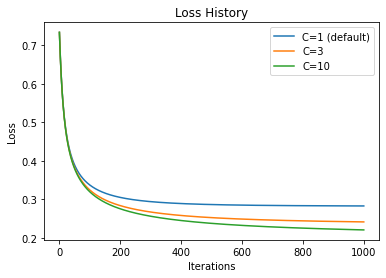

In [22]:
model_C_3 = CustomLogisticRegression(C=3)
model_C_3.fit(X_train, y_train)
model_C_10 = CustomLogisticRegression(C=10)
model_C_10.fit(X_train, y_train)

plt.plot(model.loss_history, label='C=1 (default)')
plt.plot(model_C_3.loss_history, label='C=3')
plt.plot(model_C_10.loss_history, label='C=10')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

Model quality gets a little bit better with higher C inverse of regularization strength.

**(0.5 points)** Compare zero initialization and random initialization. 

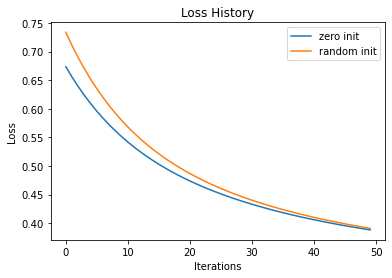

In [23]:
model_zero_init = CustomLogisticRegression(zero_init=True)
model_zero_init.fit(X_train, y_train)

plt.plot(model_zero_init.loss_history[:50], label='zero init')
plt.plot(model.loss_history[:50], label='random init')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

Zero initialization has a slightly better start than random initialization.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [24]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.sqrt(((np.expand_dims(X, 0) - np.expand_dims(Y, 1)) ** 2).sum(axis=-1)).T
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        class_weights = []
        for i in self.classes_:
            summary = 0
            for j in range(len(y)):
                if i == y[j]:
                    summary += weights[j]
            class_weights.append(summary)
        return class_weights
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            nearest_neighbors = P.argsort(axis=1)[:, :self.n_neighbors]
            weights_ = np.ones(self.y[nearest_neighbors].shape)
            
            if self.weights == 'distance':
                weights_ = 1 / np.maximum(P[np.arange(P.shape[0])[:, None], nearest_neighbors], self.eps)
                
            count_labels = np.array([self.get_class_weights(self.y[nearest_neighbors][i], weights_[i]) 
                                     for i in range(len(P))])
            weights_of_points = count_labels / np.tile(count_labels.sum(axis=1), (count_labels.shape[1], 1)).T
            return np.array(weights_of_points)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis=1)

In [25]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [26]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

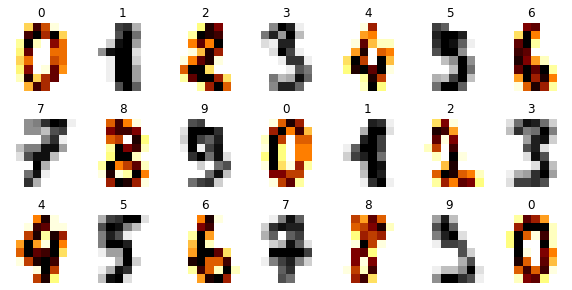

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [30]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

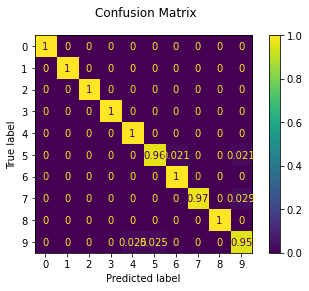

In [31]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [32]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

The model confuses 5 with 6, 5 with 9, 7 with 9, 9 with 4, 9 with 5, because these numbers ha

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

No handles with labels found to put in legend.


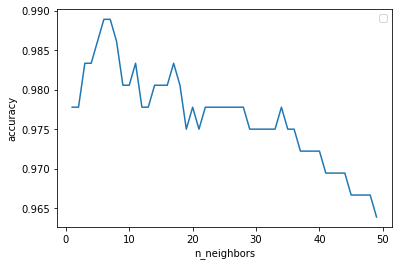

In [33]:
accuracy = []
n_neighbors = list(range(1, 50, 1))

for i in n_neighbors:
    knn = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    accuracy.append(metrics.accuracy_score(y_pred=knn.predict(X_test), y_true=y_test))
    
plt.plot(n_neighbors, accuracy)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.legend()

n_neighbors: 1


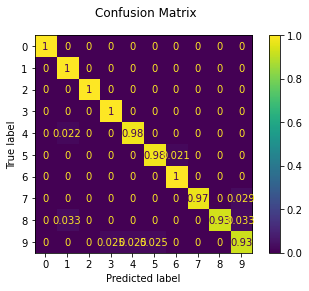

n_neighbors: 5


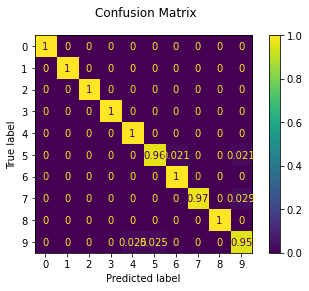

n_neighbors: 9


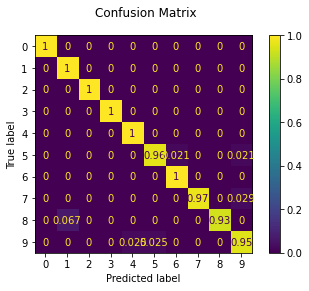

n_neighbors: 13


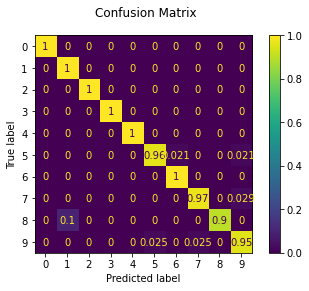

n_neighbors: 17


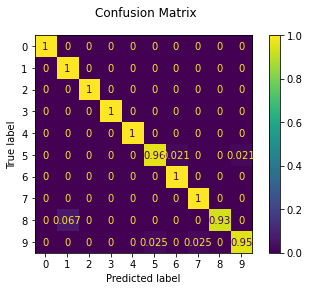

In [34]:
n_neighbors = list(range(1, 20, 4))

for i in n_neighbors:
    print(f'n_neighbors: {i}')
    fit_evaluate(CustomKNeighborsClassifier(n_neighbors=i, weights='distance'), X_train, y_train, X_test, y_test)

In [35]:
np.array(accuracy).argmax()

5

Optimal number of neighbors is 5. Lower values of K mean that the predictions calculated by KNN are less stable and reliable. Higher number of neighbors reduces the accuracy (see the plot above). As the radius that the KNN model considers increases, it will eventually start considering data points that are closer to other groups than they are the target data point and misclassification will start occurring.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

uniform


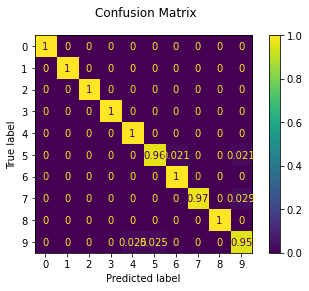

uniform accuracy: 0.9895615866388309 0.9861111111111112
distance


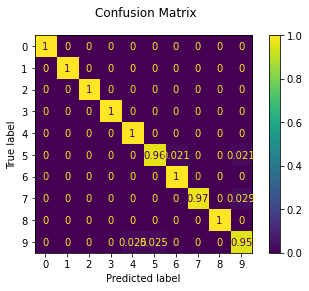

distance accuracy 1.0 0.9861111111111112


In [36]:
print('uniform')
train_acc, test_acc = fit_evaluate(CustomKNeighborsClassifier(n_neighbors=5, weights='uniform'), X_train, y_train, X_test, y_test)
print('uniform accuracy:', train_acc, test_acc)
print('distance')
train_acc, test_acc = fit_evaluate(CustomKNeighborsClassifier(n_neighbors=5, weights='distance'), X_train, y_train, X_test, y_test)
print('distance accuracy', train_acc, test_acc)

'uniform' weights - all points in each neighborhood are weighted equally.  
'distance' weight points by the inverse of their distance - closer neighbors of a query point will have a greater influence than neighbors which are further away.  
It's a good illustation of the bias-variance tradeoff. 'distance' reduces the bias by down-weighting data point that are less similar, but by doing that in increases the variance. 'uniform' does the opposite, it reduces variance by ensuaring each of the nearest neighbors has the same contribution.  
So you might want to go for 'distance' when you feel like your model is underfitted.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Euclidean distance is the most used type. Manhattan, Hamming, Minkowski (default, pseudo-Euclidean), Jaccard, a lot of others distance are different alternatives.  
It's hard to suggest distance metric which could improve the quality of this task (would give higher accuracy).

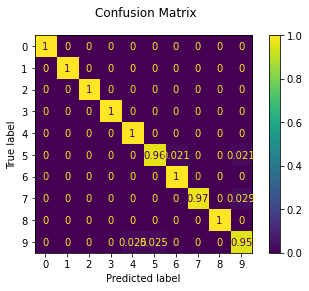

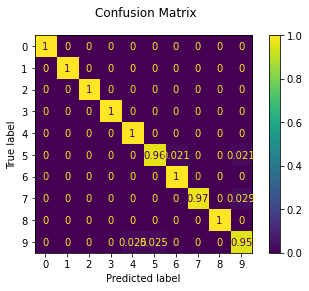

(1.0, 0.9861111111111112)

In [37]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski')
fit_evaluate(knn, X_train, y_train, X_test, y_test)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
fit_evaluate(knn, X_train, y_train, X_test, y_test)

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

*Cosine Distance* â€“ This distance metric is used mainly to calculate similarity between two vectors. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in the same direction. It is often used to *measure document similarity in text analysis*. 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [58]:
PATH = "./data/"

In [59]:
data = pd.read_csv(os.path.join('..', '..', PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [60]:
test = pd.read_csv(os.path.join('..', '..', PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [61]:
data.head()

Survived  Pclass              Name   Sex    Age  SibSp  Parch  \
PassengerId                                                                  
0                   1       1  Oconnor, Frankie  male    NaN      2      0   
1                   0       3       Bryan, Drew  male    NaN      0      0   
2                   0       3    Owens, Kenneth  male   0.33      1      2   
3                   0       3     Kramer, James  male  19.00      0      0   
4                   1       3     Bond, Michael  male  25.00      0      0   

                Ticket   Fare   Cabin Embarked  
PassengerId                                     
0               209245  27.14  C12239        S  
1                27323  13.35     NaN        S  
2            CA 457703  71.29     NaN        S  
3             A. 10866  13.04     NaN        S  
4               427635   7.76     NaN        S

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

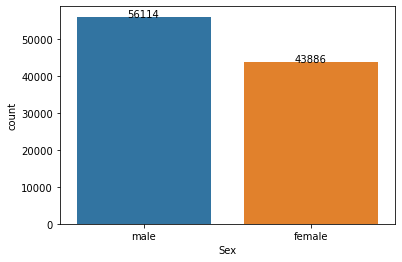

In [62]:
ax = sns.countplot(x='Sex', data=data)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()))

plt.show()

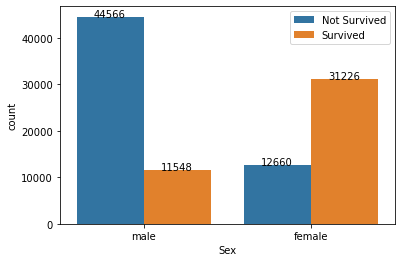

In [63]:
ax = sns.countplot(x='Sex', hue='Survived', data=data)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.1, p.get_height()))

plt.legend(labels=['Not Survived', 'Survived'])
plt.show()

There were more male (56114) than female (43886). Female (71%) are more likely to survive than male (21%).

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [64]:
data.groupby('Survived')['Age'].describe()

count       mean        std   min   25%   50%   75%   max
Survived                                                             
0         55290.0  36.708695  17.809058  0.08  24.0  36.0  52.0  83.0
1         41418.0  40.553799  18.742172  0.08  27.0  43.0  55.0  87.0

Average age of survived 41, deceased - 37. Median age of survived 43, deceased - 36.

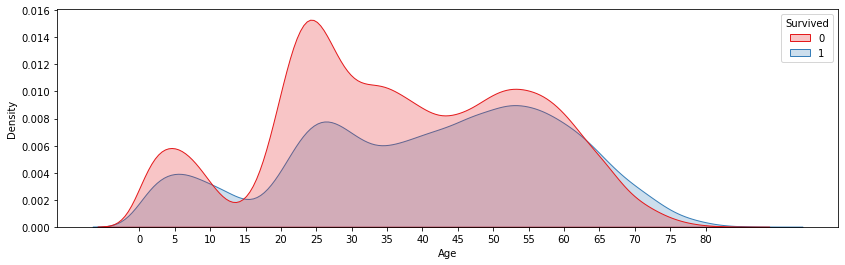

In [65]:
plt.figure(figsize=(14, 4))
sns.kdeplot(x='Age', data=data, hue='Survived', fill=True, palette='Set1')
plt.xticks([x for x in range(0, 85, 5)])
plt.show()

Elderly people more likely to survive (age 65 and higher) and children with age between 11 and 14.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

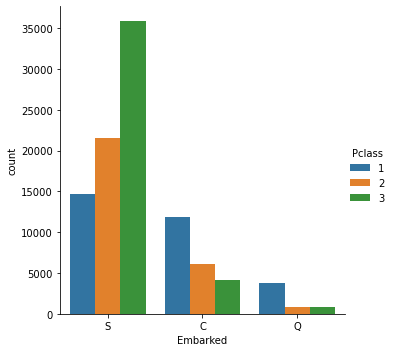

In [66]:
sns.catplot(x='Embarked', hue='Pclass', kind="count", data=data)
plt.show()

People from higher passenger classes had port of embarkation - Cherbourg and Queenstown.

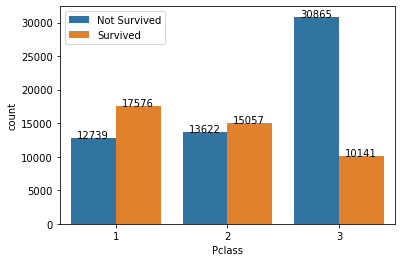

In [67]:
ax = sns.countplot(x='Pclass', hue='Survived', data=data)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.05, p.get_height()))

plt.legend(labels=['Not Survived', 'Survived'])
plt.show()

In [68]:
data[['Pclass', 'Survived']] \
    .groupby(['Pclass'], as_index=False) \
    .mean() \
    .sort_values(by='Survived', ascending=False)

Pclass  Survived
0       1  0.579779
1       2  0.525018
2       3  0.247305

If you are in 1st or 2nd class you are more likely (58% & 53%) to survive than in 3rd class (25%).

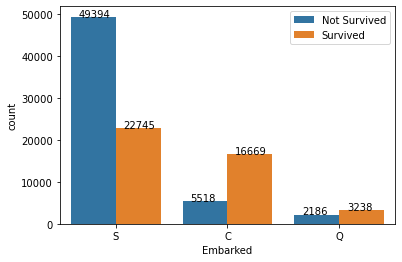

In [69]:
ax = sns.countplot(x='Embarked', hue='Survived', data=data)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.07, p.get_height()))

plt.legend(labels=['Not Survived', 'Survived'])
plt.show()

If your port of embarkation is Cherbourg you have higher chances to survive. If Queenstown - you are more likely to survive than not. If Southampton - you are more likely to not survive.  

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [70]:
data.isnull().sum().sort_values(ascending=False)

Cabin       67866
Ticket       4623
Age          3292
Embarked      250
Fare          134
Survived        0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
dtype: int64

Percentage of missing values for each feature:

In [71]:
data.isnull().sum().sort_values(ascending=False) * 100 / len(data)

Cabin       67.866
Ticket       4.623
Age          3.292
Embarked     0.250
Fare         0.134
Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
SibSp        0.000
Parch        0.000
dtype: float64

<AxesSubplot:ylabel='PassengerId'>

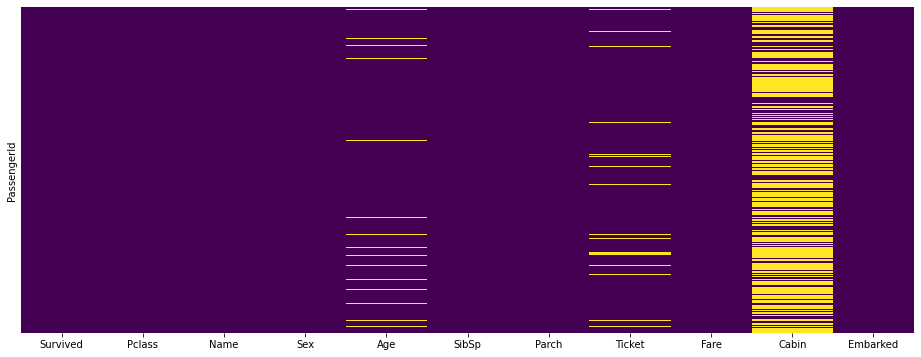

In [72]:
plt.figure(figsize=(16, 6))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can handle missing values by filling out by mean or median for quantitive ones, or fill out as 'U' (undefined) for categorical or drop all together if there are a lot of missed values (Cabin 67% missed).

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [74]:
def clean(data):
    cols = ['Fare', 'Age']
    for col in cols:
        data[col].fillna(data[col].median(), inplace=True)
    
    data['Embarked'].fillna('U', inplace=True)
    
    data['Family'] = data['Parch'] + data['SibSp']
    
    data['Deck'] = data['Cabin'].str[0]
    data['Deck'].fillna('U', inplace=True)
    
    data = data.drop(['Ticket', 'Name', 'Cabin', 'SibSp', 'Parch'], axis=1)
    
    return data

data = clean(data)
test = clean(test)

In [75]:
data.head(5)

Survived  Pclass   Sex    Age   Fare Embarked  Family Deck
PassengerId                                                            
0                   1       1  male  39.00  27.14        S       2    C
1                   0       3  male  39.00  13.35        S       0    U
2                   0       3  male   0.33  71.29        S       3    U
3                   0       3  male  19.00  13.04        S       0    U
4                   1       3  male  25.00   7.76        S       0    U

In [76]:
le = preprocessing.LabelEncoder()
cols = ['Sex', 'Embarked', 'Deck']

for col in cols:
    data[col] = le.fit_transform(data[col])
    test[col] = le.transform(test[col])
    print(le.classes_)

data.head(5)

['female' 'male']
['C' 'Q' 'S' 'U']
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'U']


Survived  Pclass  Sex    Age   Fare  Embarked  Family  Deck
PassengerId                                                             
0                   1       1    1  39.00  27.14         2       2     2
1                   0       3    1  39.00  13.35         2       0     8
2                   0       3    1   0.33  71.29         2       3     8
3                   0       3    1  19.00  13.04         2       0     8
4                   1       3    1  25.00   7.76         2       0     8

In [77]:
X = data.drop('Survived', axis=1)
y = data['Survived']

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Crossvalidation:

In [79]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [80]:
kf = KFold(n_splits=10, random_state=None)
clf = LogisticRegression()
result = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
print(result.mean())

0.76511


In [81]:
clf = KNeighborsClassifier(n_neighbors=5)
result = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
print(result.mean())

0.7259800000000001


Accuracy for LogisticRegression is higher than KNN: 0.76 vs 0.72. Let's use LogisticRegession.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Hyperparameters tuning:

In [83]:
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()

parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

clf = GridSearchCV(
    logreg,
    param_grid=parameters,
    scoring='accuracy',
    cv=10
)

In [84]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [85]:
clf.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [86]:
clf.best_score_

0.7660875

In [87]:
logreg = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(test)

In [88]:
logreg.score(X_val, y_val)

0.7674

In [89]:
submission_preds = clf.predict(test)

In [90]:
df = pd.DataFrame({
    'PassengerId': test.index.values,
    'Survived': submission_preds
})

In [91]:
df.to_csv('submission.csv', index=False)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Max public score reached by me is 0.78856.